# Similarity Metrics and Optimization

### Learning Objectives

* Survey metrics used to quantify image similarity 
* Show, in a practical way, how similarity metrics behave i
* Present registration as an optimization problem whose objective is to find the optimal spatial transform in the presence of image noise and plausible transformations

## Similarity Metrics

Similarity metrics quatify the difference between moving and reference images, and are used as objective functions during the optimization process. Bellow we deffine the _sum of squares error_, _sum of absolute difference_, _cross-correlation coefficient_ and _mutual information_ metrics, which are among the most popular metrics used in registration.

Sum of squared error:
$$ \frac{1}{N}\sum_j[I_m(j) - I_r(j)]^2 $$

Sum of absolute values:
$$
\frac{1}{N}\sum_j[|I_m(j) - I_r(j)|]
$$

Cross-correlation coefficient:
$$
\frac{\sum_j(I_m(j) - \mu I_m(j))(I_r - \mu I_r(j))}{\sqrt{\sum_j(I_m(j) - \mu I_m(j))^2 \sum_j(I_r(j) - \mu I_r(j))^2}}
$$

Mutual-information:
$$
H(I_m) + H(I_r) + H(I_m,I_r)
$$
with
$$
H(I_m) = -\sum p_m(i)log[p_m(i)]
$$
$$
H(I_r) = -\sum p_r(i)log[p_r(i)]
$$
$$
H(I_m,I_r) = - \sum \sum p_{mr}(i,j)log[p_{mr}(i,j)]
$$

In [ ]:
%matplotlib notebook

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import skimage.io as io
import numpy as np
import skimage.transform as tf
from skimage import img_as_ubyte
from scipy.ndimage.filters import maximum_filter, minimum_filter
from scipy.optimize import fmin_powell,fmin

Let's define our similarity metrics:

In [2]:
#sum of squared errors
def sse(img_mov, img_ref):
    img1 = img_mov.astype('float64')
    img2 = img_ref.astype('float64')
    r = (img1 - img2)**2
    sse = np.sum(r.ravel())
    sse /= r.ravel().shape[0]
    return sse

#sum of absolute value
def sav(img_mov, img_ref):
    img1 = img_mov.astype('float64')
    img2 = img_ref.astype('float64')
    ab = np.abs(img1 - img2)
    sav = np.sum(ab.ravel())
    sav /= ab.ravel().shape[0]
    return sav

def xcorr(img_mov,img_ref):
    # Vectorized versions of c,d,e
    a = img_mov.astype('float64')
    b = img_ref.astype('float64')

    # Calculating mean values
    AM = np.mean(a)
    BM = np.mean(b)

    c_vect = (a - AM) * (b - BM)
    d_vect = (a - AM) ** 2
    e_vect = (b - BM) ** 2

    # Finally get r using those vectorized versions
    r_out = np.sum(c_vect) / float(np.sqrt(np.sum(d_vect) * np.sum(e_vect)))
    return r_out

def mutual_information(img_mov,img_ref):
    hgram, x_edges, y_edges = np.histogram2d(img_mov.ravel(), img_ref.ravel(), bins=20)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

### Rigid body transformation
Here we define our rigid body transformation and registration function. Remember that regid body transformations only allow translations and rotations.

In [3]:
def rigid_tform(img_ref,par):
    tx = par[0] #x axis translation
    ty = par[1] #y axis translation
    theta = par[2] # rotation, covert to in radians

    center = np.array((img_ref.shape[0], img_ref.shape[1])) / 2
    tform1 = tf.SimilarityTransform(translation=center)
    tform2 = tf.SimilarityTransform(rotation=theta)
    tform3 = tf.SimilarityTransform(translation=-center)
    tform4 = tf.SimilarityTransform(translation=(tx, ty))
    tform = tform4 + tform3 + tform2 + tform1
    tform.params[2] = (0, 0, 1)

    img_mov = tf.warp(img_ref, tform)
    img_mov = img_as_ubyte(img_mov)

    return img_mov

In [34]:
# img_mv is the _moving image_, img_rf is the _reference image_. 
# Dx, dy and dt are arrays with x,y translation and t rotations.
# roi changes the considered region of interest
def do_registration(img_mv, img_rf, dx, dy, dt, roi = None, vis = False):
    if vis:
        fig = plt.figure(figsize=(10, 6))
        ax1 = fig.add_subplot(231)
        ax1.axis('off')
        ax1.title.set_text('Reference image')
        ax2 = fig.add_subplot(232)
        ax2.axis('off')
        ax2.title.set_text('Moving image')
        ax3 = fig.add_subplot(233)
        ax3.axis('off')
        ax3.title.set_text('Alignment')
        ax4 = fig.add_subplot(235)
        ax4.title.set_text('Mutual information')
        ax4.set_xlabel('iteration')

        ax1.imshow(img_ref, cmap='gray')
        mpts = []

    if roi is None:
        roi = np.array([0,0,img_rf.shape[0],img_rf.shape[1]]) # assume both images have the same size
    elif vis: # plot ROI
        recw = roi[3] - roi[1] #width
        rech = roi[2] - roi[0] #height
        ax1.add_patch(patches.Rectangle((roi[1], roi[0]), recw, rech, fill=None, alpha=1, edgecolor='red'))
        ax2.add_patch(patches.Rectangle((roi[1], roi[0]), recw, rech, fill=None, alpha=1, edgecolor='red'))


    metrics = np.zeros((dx.shape[0], dy.shape[0], dt.shape[0], 4))
    len_Dx = len(dx) #x shift
    len_Dy = len(dy) #y shift
    len_Dt = len(dt) #range of thetas in radians
    for i in range(len_Dy):
        for j in range(len_Dx):
            for t in range(len_Dt):
                th = dt[t]
                tx = dx[i]
                ty = dy[j]

                img_reg = rigid_tform(img_mv,(tx,ty,th))
                img_disp = np.zeros((img_mv.shape[0], img_mv.shape[1], 3), dtype='uint8')
                img_disp[:, :, 0] = img_rf
                img_disp[:, :, 1] = img_reg

                mi = mutual_information(img_reg[roi[0]:roi[2],roi[1]:roi[3]], img_rf[roi[0]:roi[2],roi[1]:roi[3]]) #just do evaluation inside roi
                se = sse(img_reg[roi[0]:roi[2],roi[1]:roi[3]], img_rf[roi[0]:roi[2],roi[1]:roi[3]])
                sa = sav(img_reg[roi[0]:roi[2],roi[1]:roi[3]], img_rf[roi[0]:roi[2],roi[1]:roi[3]])
                xc = xcorr(img_reg[roi[0]:roi[2],roi[1]:roi[3]], img_rf[roi[0]:roi[2],roi[1]:roi[3]])

                metrics[i, j, t, 0] = mi
                metrics[i, j, t, 1] = se
                metrics[i, j, t, 2] = sa
                metrics[i, j, t, 3] = xc

                if vis:
                    mpts.append(mi)  # change here to vis different metrics
                    ax2.imshow(img_reg, cmap='gray')  # moving image
                    ax3.imshow(img_disp)  # overlap
                    ax4.plot(mpts, 'b-')  # metric live graph
                    fig.canvas.draw()
                    plt.pause(0.1)

    return metrics

Here we define some boiler plate code for visualization of our similarity metrics:

In [5]:
def find_global_max(mat,X,Y):
    #find global maxima
    rmx, cmx = np.unravel_index(mat.argmax(), mat.shape)
    xmax = X[rmx,cmx]
    ymax = Y[rmx,cmx]

    return xmax,ymax

def find_global_min(mat,X,Y):
    #find global minima
    rmi, cmi = np.unravel_index(mat.argmin(), mat.shape)
    xmin = X[rmi,cmi]
    ymin = Y[rmi,cmi]

    return xmin,ymin

def find_local_maxs(mat,X,Y):
    #find local maximums
    local_max = maximum_filter(mat,size=(3,3), mode='constant', cval=0)
    lmx_rows,lmx_cols = np.nonzero(local_max == mat)
    maxs = [(X[rc],Y[rc]) for rc in zip(lmx_rows,lmx_cols)]
    maxs = np.array(maxs)

    return maxs

def find_local_min(mat,X,Y):
    #find local minimums
    local_min = minimum_filter(mat,size=(3,3), mode='constant', cval=mat.max())
    lmi_rows,lmi_cols = np.nonzero(local_min == mat)
    mins = [(X[rc],Y[rc]) for rc in zip(lmi_rows,lmi_cols)]
    mins = np.array(mins)

    return mins

In [6]:
def display_metric(metric, X, Y, title):
    xmax,ymax = find_global_max(metric,X,Y)
    xmin,ymin = find_global_min(metric,X,Y)
    maxs = find_local_maxs(metric,X,Y)
    mins = find_local_min(metric,X,Y)

    fig = plt.figure(figsize=(9,4))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    ax1.plot_surface(X, Y, metric, linewidth=0, cmap='viridis', antialiased=False)
    ax1.title.set_text(title)
    ax1.set_xlabel('Dx')
    ax1.set_ylabel('Dy')

    cset = ax2.contour(X,Y,metric, colors='black')
    ax2.clabel(cset, inline=1, fontsize=5)
    ax2.contourf(X, Y, metric, cmap='viridis')

    ax2.plot(maxs[:,0],maxs[:,1],'r+', label='local max')
    ax2.plot(mins[:,0],mins[:,1],'bo', label='local min')
    ax2.plot(xmax,ymax,marker='*', markersize=8, markerfacecolor='red', label='global max')
    ax2.plot(xmin,ymin,marker='o', markersize=8, markerfacecolor='red', label='global min')

    ax2.title.set_text(title)
    ax2.set_xlabel('Dx')
    ax2.set_ylabel('Dy')
    ax2.set_xlim([dx.min()-1, dx.max()+1])
    ax2.set_ylim([dy.min()-1, dy.max()+1])
    ax2.legend(loc="lower right")
    plt.show()

## Exercise 1: Phatom to Phatom Registration
In this exercise we will do a very basic registration using phantom images. The goal is to
* (1) define a range of translations dx and dy
* (2) run the registration and visualize how different similarity metrics behave. You will notice that while some metric values will increase as the images get aligned, some will decrease.
* (3) manually selec a range of translations and rotations that seem to give the best registration
* (4) run the registration again and find the best set of parameters (x translations, y translation and t rotation) that give the best alignment. 

In [7]:
%matplotlib notebook

metric_names = ['Mutual information','Sum of squared errors','Sum of absolute value','Cross correlation coef.']
nMetrics = 4

First, run the registration:

/home/maryana/bin/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


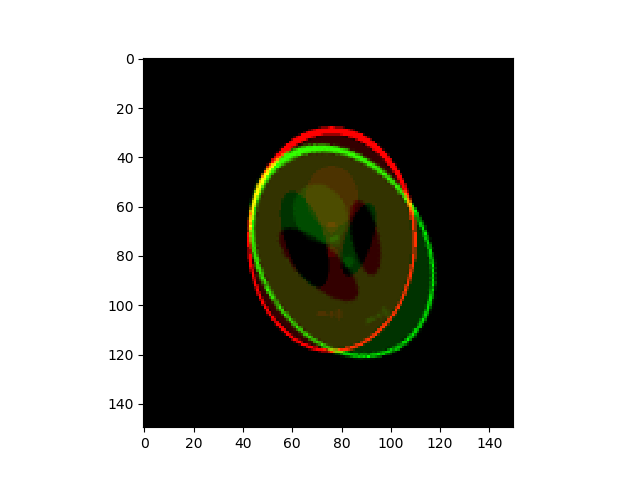

In [8]:
#load original image
img_ref = io.imread('imgs/phantom2.tif')

#create a moving image for testing
theta = np.deg2rad(30)
par = (-5,-5,theta)
img_mov = rigid_tform(img_ref,par)

img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_mov

plt.imshow(img_disp)

In [9]:
#run registration
dx = np.arange(-8,16,2)
dy = np.arange(-8,16,2)
dt = np.array([0])
X, Y = np.meshgrid(dx, dy)

#set vis=True if you want to visualize the registration process in real-time
#note that for this first test, we are only considering translations and setting rotations = 0
metrics = do_registration(img_mov, img_ref, dx, dy, dt, vis=True)

Now visualize all the similarity metric values:

<IPython.core.display.Javascript object>


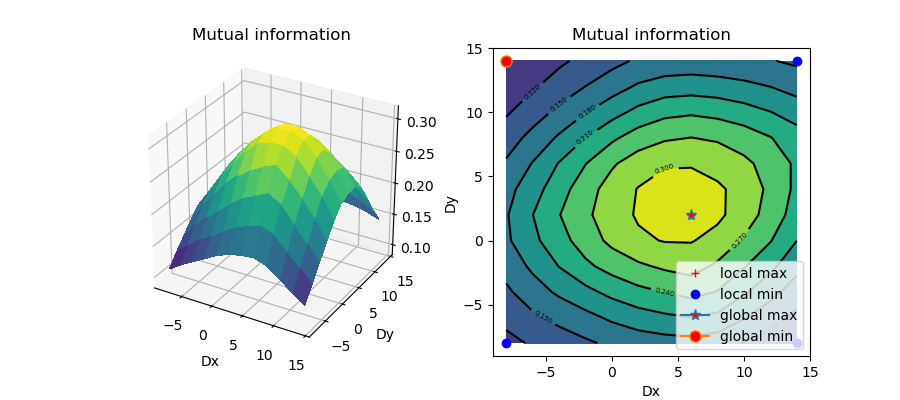

In [10]:
m_idx = 0
#note that we are setting the rotation angle array index to 0
display_metric(metrics[:,:,0,m_idx],X,Y,metric_names[m_idx])

<IPython.core.display.Javascript object>


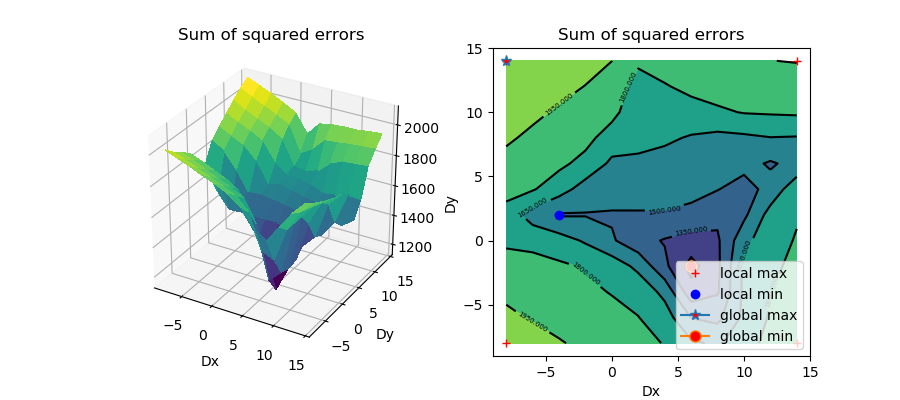

In [11]:
m_idx = 1
display_metric(metrics[:,:,0,m_idx],X,Y,metric_names[m_idx])

<IPython.core.display.Javascript object>


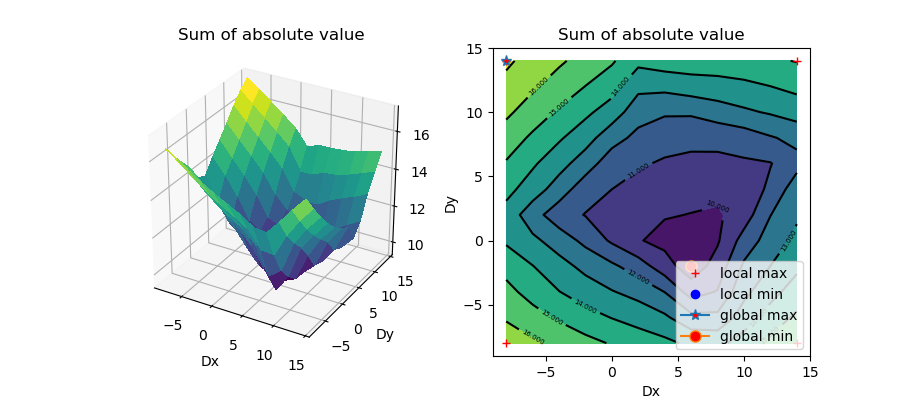

In [12]:
m_idx = 2
display_metric(metrics[:,:,0,m_idx],X,Y,metric_names[m_idx])

<IPython.core.display.Javascript object>


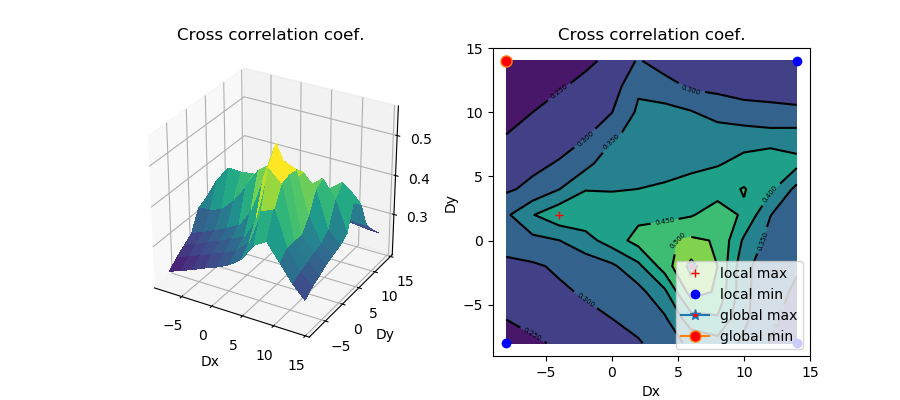

In [13]:
m_idx = 3
display_metric(metrics[:,:,0,m_idx],X,Y,metric_names[m_idx])

From the graphs above, we can see that there is a good registration in the range of [5,10]. No let's re-run the registration within this range and add some rotations:

In [14]:
#run do_registration() again with a constrained dy,dx range and a range of thetas to find the best angle
dxf = np.arange(5,10,0.5)
dyf = np.arange(5,10,0.5)
dtf = np.arange(-np.pi/4,np.pi/4,np.pi/45)
Xf, Yf = np.meshgrid(dxf, dyf)
metrics_fine = do_registration(img_mov, img_ref, dxf, dyf, dtf)

Let's get the set of parameters that maximize the metric. Note that here we are using Mutual Information, if you were to use a different metric, like SSE, you'd need to find the parameters that minimize the matric.

In [15]:
#let's use MI
metric_fine = metrics_fine[...,0]

#get global max
rmx, cmx, tmx = np.unravel_index(metric_fine.argmax(), metric_fine.shape)
xmax = Xf[rmx,cmx]
ymax = Yf[rmx,cmx]
tmax = dtf[tmx]

print('X shift:{} Y shift:{} Theta: {}'.format(xmax,ymax, tmax))

X shift:6.5 Y shift:5.0 Theta: -0.36651914291880927


Now transform the moving image using the set of parameter you just computed:

<IPython.core.display.Javascript object>


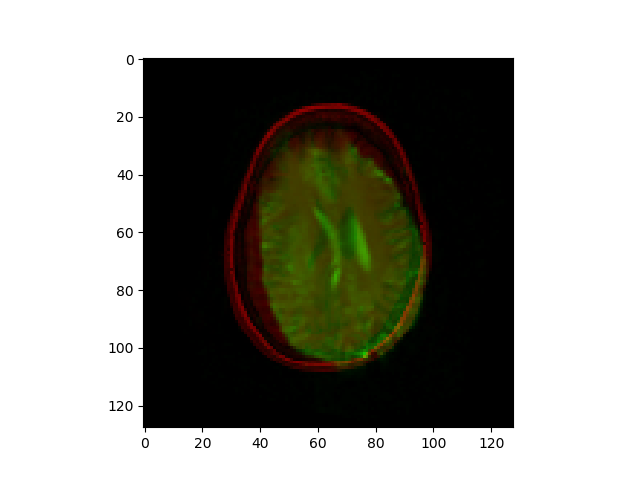

In [35]:
#do final registration
img_reg_final = rigid_tform(img_mov,(xmax,ymax,tmax))
img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_reg_final
plt.figure()
plt.imshow(img_disp)

### Challenge 
Change the code to use another metric of your choise, such as cross-correlation or sse. Don't forget to adjust the code to find the minimum instead of maximum, if necessary.

## Exercise 2: MRI to fMRI registration
Exercise 2 will be similar to exercise 1, except that we will use real MRI and fMRI data.

In [18]:
#load images
img_ref = io.imread('imgs/spge.tif')
img_mov = io.imread('imgs/fmri_tr2.tif')

dx = np.arange(-8,30,2)
dy = np.arange(-8,30,2)
dt = np.array([0])
X, Y = np.meshgrid(dx, dy)

/home/maryana/bin/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:1635: UserWarning: can not reshape (128, 128) to (512, 512)
  warnings.warn(str(e))


For this exercise we are setting the ROI as the full images. However, it is really insteresting to change the ROI to a smaller region and see how it affects the similarity metrics. Reducing the ROI will reduce what is called the _capture range_ of the registration, possibly causing local minimas/maximas and making the registration problem more difficult. 

In [19]:
#test ROI
#ROI = np.array([38,44,92,84])
ROI = None
metrics_mri = do_registration(img_mov, img_ref, dx, dy, dt, ROI, vis=False)

<IPython.core.display.Javascript object>


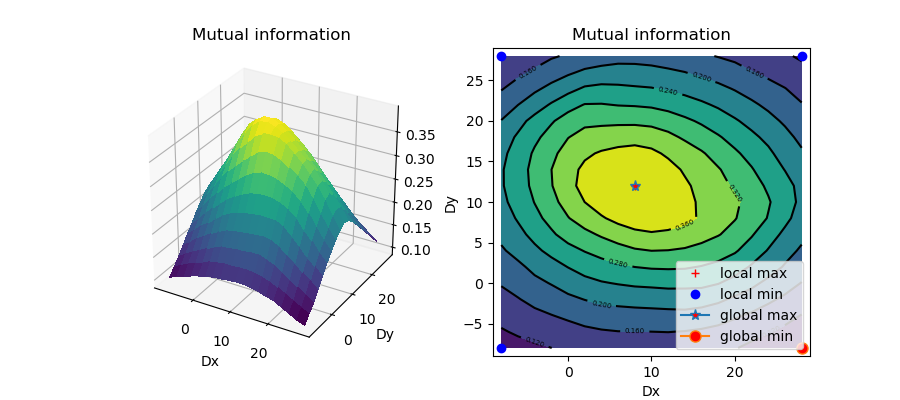

In [20]:
m_idx = 0
display_metric(metrics_mri[:,:,0,m_idx],X,Y,metric_names[m_idx])

<IPython.core.display.Javascript object>


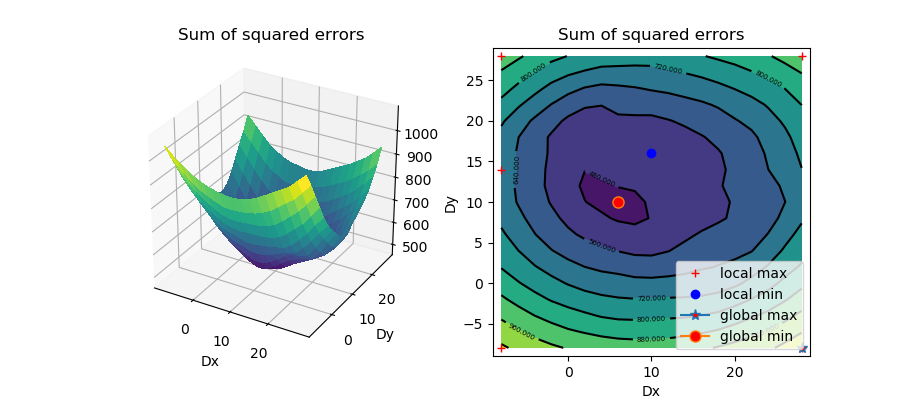

In [21]:
m_idx = 1
display_metric(metrics_mri[:,:,0,m_idx],X,Y,metric_names[m_idx])

<IPython.core.display.Javascript object>


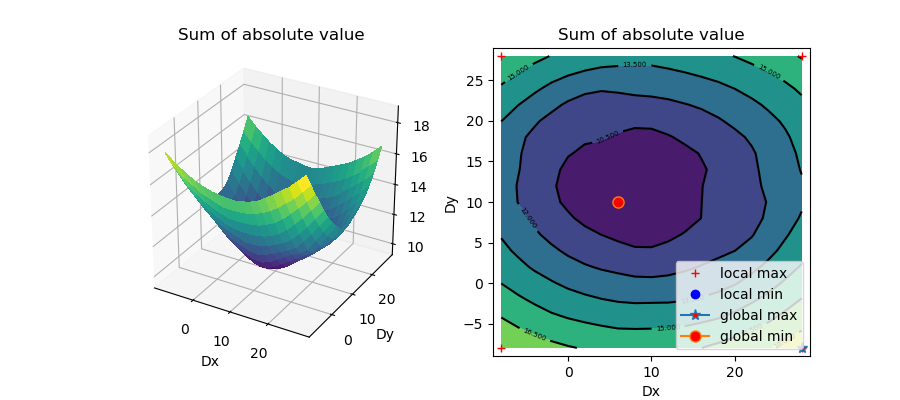

In [22]:
m_idx = 2
display_metric(metrics_mri[:,:,0,m_idx],X,Y,metric_names[m_idx])

<IPython.core.display.Javascript object>


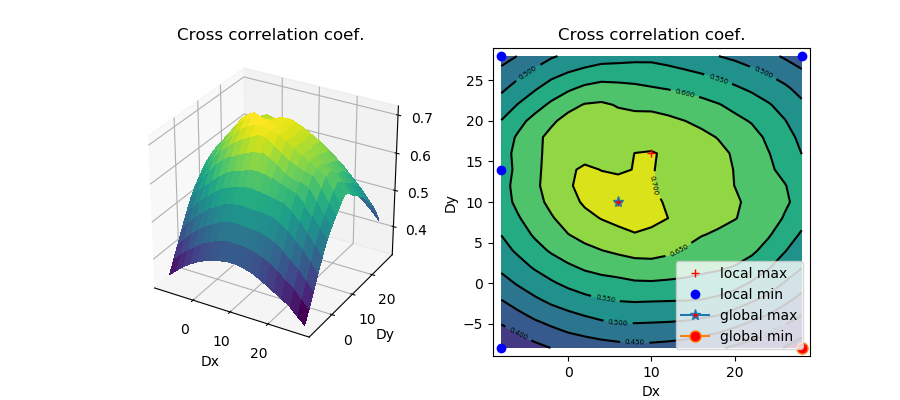

In [23]:
m_idx = 3
display_metric(metrics_mri[:,:,0,m_idx],X,Y,metric_names[m_idx])

In [24]:
#run do_registration() again with a constrained dy,dx range and a range of thetas to find the best angle
dxf = np.arange(2,10,0.5)
dyf = np.arange(2,10,0.5)
dtf = np.arange(-np.pi/4,np.pi/4,np.pi/45)
Xf, Yf = np.meshgrid(dxf, dyf)
metrics_fine = do_registration(img_mov, img_ref, dxf, dyf, dtf)

In [25]:
#let's use MI
metric_fine = metrics_fine[...,0]

#get global max
rmx, cmx, tmx = np.unravel_index(metric_fine.argmax(), metric_fine.shape)
xmax = Xf[rmx,cmx]
ymax = Yf[rmx,cmx]
tmax = dtf[tmx]

print('X shift:{} Y shift:{} Theta: {}'.format(xmax,ymax, tmax))

X shift:9.5 Y shift:9.5 Theta: -0.2967059728390361


<IPython.core.display.Javascript object>


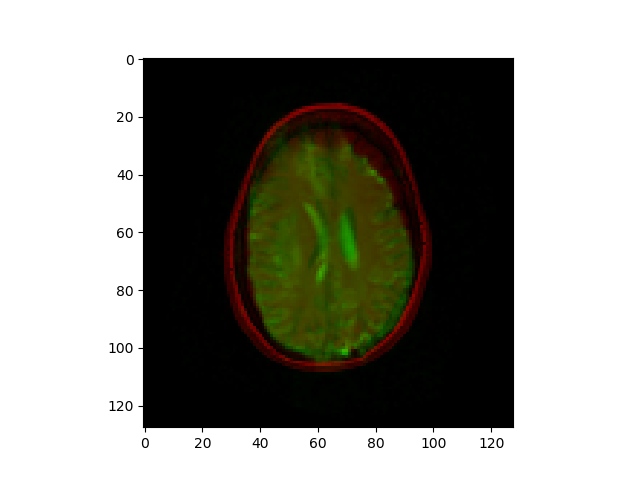

In [26]:
#do final registration
img_reg_final = rigid_tform(img_mov,(xmax,ymax,tmax))
img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_reg_final
plt.figure()
plt.imshow(img_disp)

In [27]:
#now let's test using SSE
metric_fine = metrics_fine[...,1]

rmx, cmx, tmx = np.unravel_index(metric_fine.argmin(), metric_fine.shape)
xmax = Xf[rmx,cmx]
ymax = Yf[rmx,cmx]
tmax = dtf[tmx]

print('X shift:{} Y shift:{} Theta: {}'.format(xmax,ymax, tmax))

X shift:6.0 Y shift:7.5 Theta: -0.22689280275926293


<IPython.core.display.Javascript object>


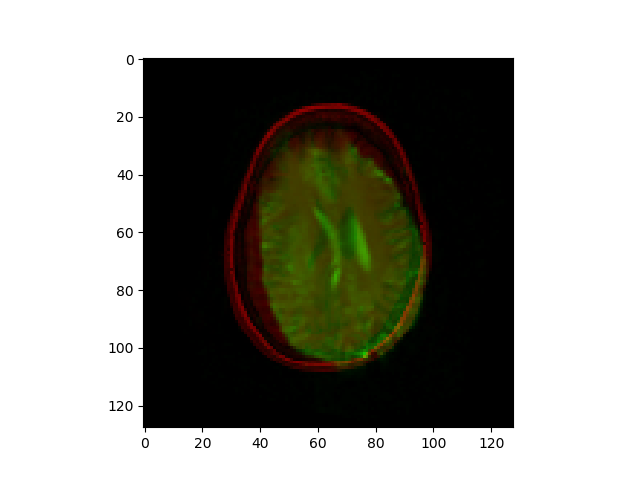

In [28]:
#do final registration
img_reg_final = rigid_tform(img_mov,(xmax,ymax,tmax))
img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_reg_final
plt.figure()
plt.imshow(img_disp)

### Challenge:
Re-run the exercise code using a smaller ROI.

## Exercise 3: Parameter Selection using Optimization
We saw on the previous exercises that manual parameter selection may now yield the best results. What if we could have an optimization algorithm doing the search for us? Could we get a better result? This is exactly how registration algorithms work in practice.

Let's define a function used by the optimizer. Note that one of the parameters is the similarity metric. 

In [29]:
# p: the set of parameters to be optimized (x trans.,y trans.,rotation)
# img_mov: moving image
# img_ref: reference image
# ismin: tells the function if it's supposed to minimize the metric
# vis: real time visualization
# pobjs: matplotlib objects
def opt_registration(p, img_mov,img_ref, metric_func, ismin, vis, pobjs):

    fig = pobjs[0] #fig,ax1,ax2,plt,ms
    ax1 = pobjs[1]
    ax2 = pobjs[2]
    plt = pobjs[3]
    ms = pobjs[4]

    img_reg = rigid_tform(img_mov,p)
    m = metric_func(img_reg,img_ref)

    img_disp = np.zeros((img_ref.shape[0], img_mov.shape[1], 3), dtype='uint8')
    img_disp[:, :, 0] = img_ref
    img_disp[:, :, 1] = img_reg

    if vis:
        ms.append(m)
        ax1.imshow(img_disp)
        ax2.plot(ms,'b-')
        fig.canvas.draw()
        plt.pause(0.1)

    if not ismin: #in not a minimizaqtion problem, used for mutual information
        m *= -1

    return m

<IPython.core.display.Javascript object>


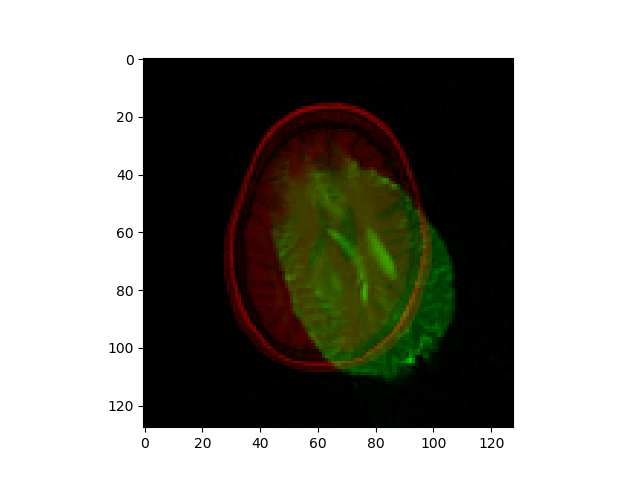

In [30]:
#load images
img_ref = io.imread('imgs/spge.tif')
img_mov = io.imread('imgs/fmri_tr2.tif')
img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_mov

plt.figure()
plt.imshow(img_disp)

<IPython.core.display.Javascript object>


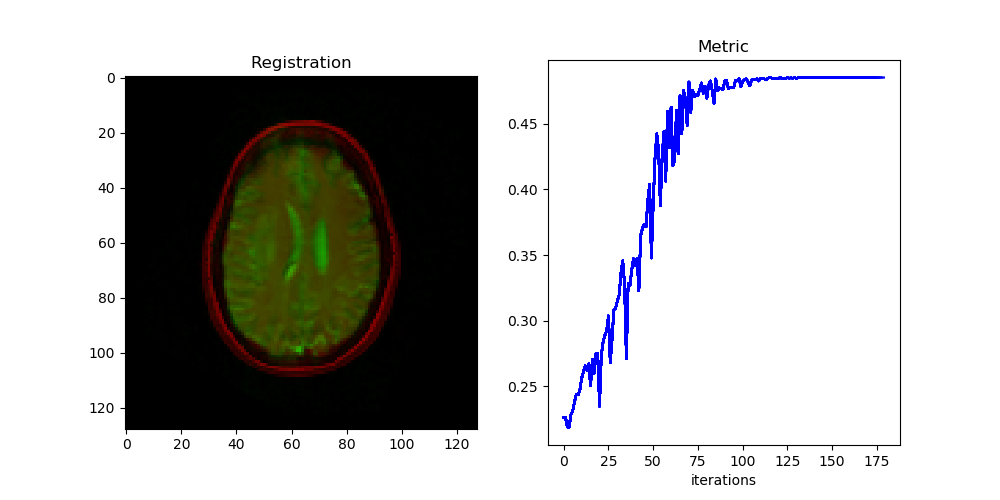

In [31]:
#initialize visualization
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.title.set_text('Registration')
ax2.title.set_text('Metric')
ax2.set_xlabel('iterations')
ms = []
plot_objs = (fig,ax1,ax2,plt,ms)

Let's run our optimizer:

In [32]:
t = [15,15,np.pi/4] #initial point
opt = fmin(opt_registration,t,args=(img_mov,img_ref, mutual_information, False, True, plot_objs),maxiter=100)
plt.close('all')
print(opt)

Optimization terminated successfully.
         Current function value: -0.485244
         Iterations: 83
         Function evaluations: 180
[ 7.29757564 14.06503316 -0.4823437 ]


Use the new parameters to transform the image:

<IPython.core.display.Javascript object>


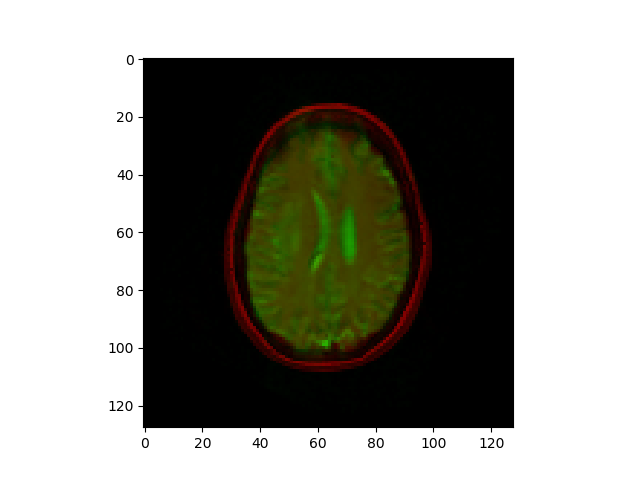

In [33]:
img_reg = rigid_tform(img_mov,opt)

img_disp = np.zeros((img_ref.shape[0],img_mov.shape[1],3),dtype='uint8')
img_disp[:,:,0] = img_ref
img_disp[:,:,1] = img_reg

plt.imshow(img_disp)

### Challenge:
Change the code above to use differente similarity metrics and see how the registration results change.

## References
* MRI images: https://na-mic.org/wiki/Projects:RegistrationDocumentation:UseCaseInventory
* This code was largely inspired by MIT 6.555 MATLAB exercises: http://web.mit.edu/6.555/www/